In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imgaug as ia
import operator
import functools
import random
from PIL import Image
from imgaug import augmenters as iaa
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)


In [2]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util
from tf_unet.image_util import ImageDataProvider

In [3]:
EPOCHS = 100
PATCH_SIZE = 128
MARGIN = 30
DISCREET_MASK = True

In [4]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= width
    assert img.shape[1] >= height
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[0] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[x:x+width, y:y+height]
    mask = mask[x:x+width, y:y+height]
    return img, mask, x, y

In [5]:
def randomPatch(img, mask, width, height):
    img_cropped, mask_cropped, x_offset, y_offset = randomCrop(img, mask, width, height)
    
    fliplr_random = np.random.random() > 0.5
    flipud_random = np.random.random() > 0.5
    
    if fliplr_random:
        img_cropped = np.fliplr(img_cropped)
        mask_cropped = np.fliplr(mask_cropped)
        
    if flipud_random:
        img_cropped = np.flipud(img_cropped)
        mask_cropped = np.flipud(mask_cropped)
        
    return img_cropped, mask_cropped, x_offset, y_offset, fliplr_random, flipud_random
    
    

In [6]:
# Define augmentation
def do_augment_data(data, labels):
    image = data
    mask = labels
    
    # more aggressive augmentation:
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Crop(percent=(0, 0.05)),
        iaa.Affine(
            scale={"x": (0.90, 1.10), "y": (0.90, 1.10)},
            translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
            rotate=(-45, 45),
            shear=(-5, 5)
        )
    ], random_order = True)

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_image(image)
    mask_aug = seq_det.augment_image(mask)

    if (DISCREET_MASK == True):
        # augmentation makes some of these values not discreet, fix them here.
        mask_aug[mask_aug > 0.5] = 1
        mask_aug[mask_aug <= 0.5] = 0
            
    return image_aug, mask_aug

In [7]:
# Create a generator that uses the Image data provider


class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='_mask.png', shuffle_data=True, augment_data=False):
        self.augment_data = augment_data
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        #im = equalize(Image.open(path).convert('L'))
        im = Image.open(path).convert('L')
        return np.array(im, dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels)
        else:
            data_aug, labels_aug = data, labels
        return data_aug, labels_aug;

In [8]:
class CropDataProvider(GrayImageDataProvider):
    def __init__(self, search_path, augment_data=False, size=PATCH_SIZE, only_positive=False):
        self.size = size
        self.only_positive = only_positive
        super(CropDataProvider, self).__init__(search_path, augment_data=augment_data)
    
    def _post_process(self, data, labels):
        while(True):
            cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data, labels, self.size, self.size)
            
            # ignore crops with CACs in the margins
#             if ([0,1] in cropped_labels[0:MARGIN, 0:self.size] or
#                 [0,1] in cropped_labels[0:self.size, 0:MARGIN] or
#                 [0,1] in cropped_labels[-MARGIN:self.size, 0:self.size] or
#                 [0,1] in cropped_labels[0:self.size, -MARGIN:self.size]):
#                 continue
            
            if(self.only_positive == True):
                if (not [0,1] in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                    continue
                
            return super(CropDataProvider, self)._post_process(cropped_data, cropped_labels)
    
    def _next_data(self):
        while(True):
            img, label = super(CropDataProvider, self)._next_data()
            if(self.only_positive == True and np.amax(label) == False):
                continue
            return img, label
                
    

In [9]:
#generator = GrayImageDataProvider("data/training/*.png", augment_data=True)
generator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True)
#generator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE)

Number of files used: 15
Number of channels: 1
Number of classes: 2


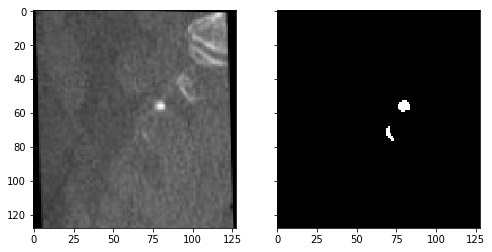

In [10]:
# visualize one of the files

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

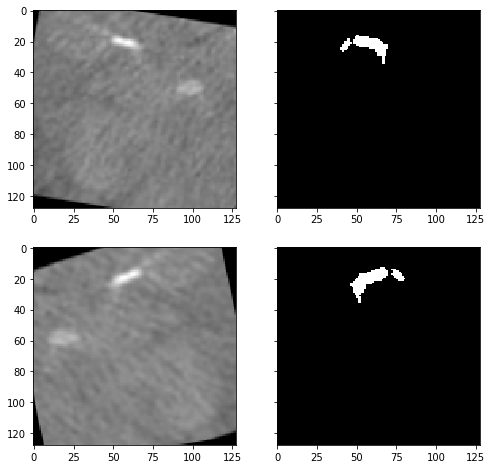

In [11]:
# visualize the augmentation

x_test, y_test = generator(1)

image = x_test[0,...,0]
mask = y_test[0,...,1]

image_aug, mask_aug = do_augment_data(image, mask)

fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
ax[0, 0].imshow(image, aspect="auto")
ax[1, 0].imshow(image_aug, aspect="auto")
ax[0, 1].imshow(mask, aspect="auto")
ax[1, 1].imshow(mask_aug, aspect="auto")



In [12]:
# The network

generator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True)
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32)
#net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32, cost_kwargs=dict(regularizer=0.001, class_weights=[1., 200.]))

2019-06-09 19:26:02,851 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 15
Number of channels: 1
Number of classes: 2
Instructions for updating:
Colocations handled automatically by placer.


2019-06-09 19:26:02,872 From /Users/nsemsarilar/code/dl/venv_tfunet/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-06-09 19:26:02,891 From /Users/nsemsarilar/code/dl/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# Train the model

#trainer = unet.Trainer(net, optimizer="momentum", batch_size=1, opt_kwargs=dict(momentum=0.2))
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(generator, "./unet_trained", training_iters=32, epochs=EPOCHS, display_step=16)



2019-06-09 19:26:04,203 Removing '/Users/nsemsarilar/code/dl/tf_unet/cbct/prediction'
2019-06-09 19:26:04,232 Removing '/Users/nsemsarilar/code/dl/tf_unet/cbct/unet_trained'
2019-06-09 19:26:04,235 Allocating '/Users/nsemsarilar/code/dl/tf_unet/cbct/prediction'
2019-06-09 19:26:04,236 Allocating '/Users/nsemsarilar/code/dl/tf_unet/cbct/unet_trained'
2019-06-09 19:26:05,144 Verification error= 2.7%, loss= 0.6787
2019-06-09 19:26:05,461 Start optimization
2019-06-09 19:26:06,281 Iter 0, Minibatch Loss= 0.6239, Training Accuracy= 0.9857, Minibatch error= 1.4%
2019-06-09 19:26:10,316 Iter 16, Minibatch Loss= 0.0941, Training Accuracy= 0.9926, Minibatch error= 0.7%
2019-06-09 19:26:13,808 Epoch 0, Average loss: 0.1747, learning rate: 0.0010
2019-06-09 19:26:14,207 Verification error= 1.2%, loss= 0.0869
2019-06-09 19:26:14,861 Iter 32, Minibatch Loss= 0.0693, Training Accuracy= 0.9912, Minibatch error= 0.9%
2019-06-09 19:26:18,921 Iter 48, Minibatch Loss= 0.0780, Training Accuracy= 0.9868, M

2019-06-09 19:29:26,080 Iter 704, Minibatch Loss= 0.0593, Training Accuracy= 0.9886, Minibatch error= 1.1%
2019-06-09 19:29:30,232 Iter 720, Minibatch Loss= 0.0370, Training Accuracy= 0.9901, Minibatch error= 1.0%
2019-06-09 19:29:34,052 Epoch 22, Average loss: 0.0467, learning rate: 0.0010
2019-06-09 19:29:34,467 Verification error= 1.2%, loss= 0.0383
2019-06-09 19:29:35,339 Iter 736, Minibatch Loss= 0.0578, Training Accuracy= 0.9902, Minibatch error= 1.0%
2019-06-09 19:29:39,465 Iter 752, Minibatch Loss= 0.0218, Training Accuracy= 0.9935, Minibatch error= 0.6%
2019-06-09 19:29:43,245 Epoch 23, Average loss: 0.0434, learning rate: 0.0010
2019-06-09 19:29:43,706 Verification error= 1.2%, loss= 0.0320
2019-06-09 19:29:44,606 Iter 768, Minibatch Loss= 0.0348, Training Accuracy= 0.9892, Minibatch error= 1.1%
2019-06-09 19:29:48,720 Iter 784, Minibatch Loss= 0.0249, Training Accuracy= 0.9899, Minibatch error= 1.0%
2019-06-09 19:29:52,572 Epoch 24, Average loss: 0.0391, learning rate: 0.001

2019-06-09 19:33:05,071 Iter 1456, Minibatch Loss= 0.0443, Training Accuracy= 0.9871, Minibatch error= 1.3%
2019-06-09 19:33:08,849 Epoch 45, Average loss: 0.0388, learning rate: 0.0010
2019-06-09 19:33:09,291 Verification error= 1.2%, loss= 0.0257
2019-06-09 19:33:10,377 Iter 1472, Minibatch Loss= 0.0330, Training Accuracy= 0.9917, Minibatch error= 0.8%
2019-06-09 19:33:14,509 Iter 1488, Minibatch Loss= 0.0364, Training Accuracy= 0.9926, Minibatch error= 0.7%
2019-06-09 19:33:18,274 Epoch 46, Average loss: 0.0335, learning rate: 0.0010
2019-06-09 19:33:18,723 Verification error= 0.9%, loss= 0.0258
2019-06-09 19:33:19,869 Iter 1504, Minibatch Loss= 0.0098, Training Accuracy= 0.9961, Minibatch error= 0.4%
2019-06-09 19:33:24,008 Iter 1520, Minibatch Loss= 0.0439, Training Accuracy= 0.9855, Minibatch error= 1.4%
2019-06-09 19:33:27,828 Epoch 47, Average loss: 0.0330, learning rate: 0.0010
2019-06-09 19:33:28,254 Verification error= 1.1%, loss= 0.0350
2019-06-09 19:33:29,406 Iter 1536, Mi

2019-06-09 19:36:53,663 Iter 2192, Minibatch Loss= 0.0162, Training Accuracy= 0.9932, Minibatch error= 0.7%
2019-06-09 19:36:57,514 Epoch 68, Average loss: 0.0269, learning rate: 0.0010
2019-06-09 19:36:58,012 Verification error= 0.7%, loss= 0.0181
2019-06-09 19:36:59,477 Iter 2208, Minibatch Loss= 0.0162, Training Accuracy= 0.9933, Minibatch error= 0.7%
2019-06-09 19:37:03,837 Iter 2224, Minibatch Loss= 0.0083, Training Accuracy= 0.9970, Minibatch error= 0.3%
2019-06-09 19:37:08,009 Epoch 69, Average loss: 0.0180, learning rate: 0.0010
2019-06-09 19:37:08,431 Verification error= 0.6%, loss= 0.0156
2019-06-09 19:37:09,779 Iter 2240, Minibatch Loss= 0.0082, Training Accuracy= 0.9974, Minibatch error= 0.3%
2019-06-09 19:37:14,091 Iter 2256, Minibatch Loss= 0.0287, Training Accuracy= 0.9946, Minibatch error= 0.5%
2019-06-09 19:37:18,527 Epoch 70, Average loss: 0.0269, learning rate: 0.0010
2019-06-09 19:37:19,066 Verification error= 0.5%, loss= 0.0150
2019-06-09 19:37:20,833 Iter 2272, Mi

2019-06-09 19:40:50,639 Iter 2928, Minibatch Loss= 0.0069, Training Accuracy= 0.9981, Minibatch error= 0.2%
2019-06-09 19:40:54,726 Epoch 91, Average loss: 0.0221, learning rate: 0.0010
2019-06-09 19:40:55,239 Verification error= 0.5%, loss= 0.0145
2019-06-09 19:40:56,900 Iter 2944, Minibatch Loss= 0.0185, Training Accuracy= 0.9938, Minibatch error= 0.6%
2019-06-09 19:41:01,104 Iter 2960, Minibatch Loss= 0.0154, Training Accuracy= 0.9954, Minibatch error= 0.5%
2019-06-09 19:41:05,099 Epoch 92, Average loss: 0.0214, learning rate: 0.0010
2019-06-09 19:41:05,573 Verification error= 0.4%, loss= 0.0122
2019-06-09 19:41:07,521 Iter 2976, Minibatch Loss= 0.0172, Training Accuracy= 0.9950, Minibatch error= 0.5%
2019-06-09 19:41:11,747 Iter 2992, Minibatch Loss= 0.0344, Training Accuracy= 0.9830, Minibatch error= 1.7%
2019-06-09 19:41:16,356 Epoch 93, Average loss: 0.0215, learning rate: 0.0010
2019-06-09 19:41:16,932 Verification error= 0.4%, loss= 0.0126
2019-06-09 19:41:19,011 Iter 3008, Mi

In [14]:
# Continued training (restore, use both negative and positive values)

negGenerator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE, only_positive=False)
net = unet.Unet(channels=negGenerator.channels, n_class=negGenerator.n_class, layers=3, features_root=32)
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(negGenerator, "./unet_trained", restore=True, training_iters=32, epochs=EPOCHS, display_step=16)



2019-06-09 19:42:21,688 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 15
Number of channels: 1
Number of classes: 2
Instructions for updating:
Use standard file APIs to check for files with this prefix.


2019-06-09 19:42:23,497 From /Users/nsemsarilar/code/dl/venv_tfunet/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-06-09 19:42:23,499 Restoring parameters from ./unet_trained/model.ckpt
2019-06-09 19:42:23,606 Model restored from file: ./unet_trained/model.ckpt
2019-06-09 19:42:24,305 Verification error= 0.0%, loss= 0.0011
2019-06-09 19:42:24,597 Start optimization
2019-06-09 19:42:25,645 Iter 0, Minibatch Loss= 0.0172, Training Accuracy= 0.9921, Minibatch error= 0.8%
2019-06-09 19:42:29,897 Iter 16, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:42:33,931 Epoch 0, Average loss: 0.0029, learning rate: 0.0010
2019-06-09 19:42:34,409 Verification error= 0.0%, loss= 0.0003
2019-06-09 19:42:35,108 Iter 32, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:42:39,318 Iter 48, Minibatch Loss= 0.0002, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:42:43,114 Epoch 1, Average loss: 0.0008, learning rate: 0.0010
2019-06-09 19:42:43,555 Verification error= 0.0%, loss= 0.0007
2019-06-09 19:42:44,238 Iter 64, Miniba

2019-06-09 19:46:10,708 Epoch 22, Average loss: 0.0061, learning rate: 0.0010
2019-06-09 19:46:11,158 Verification error= 0.0%, loss= 0.0003
2019-06-09 19:46:12,051 Iter 736, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:46:16,405 Iter 752, Minibatch Loss= 0.0004, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:46:20,489 Epoch 23, Average loss: 0.0137, learning rate: 0.0010
2019-06-09 19:46:20,975 Verification error= 0.0%, loss= 0.0044
2019-06-09 19:46:21,938 Iter 768, Minibatch Loss= 0.0073, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:46:26,559 Iter 784, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:46:30,803 Epoch 24, Average loss: 0.0115, learning rate: 0.0010
2019-06-09 19:46:31,248 Verification error= 0.0%, loss= 0.0018
2019-06-09 19:46:32,174 Iter 800, Minibatch Loss= 0.0040, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:46:36,676 Iter 816, Minibatc

2019-06-09 19:50:16,795 Epoch 45, Average loss: 0.0053, learning rate: 0.0010
2019-06-09 19:50:17,367 Verification error= 0.0%, loss= 0.0004
2019-06-09 19:50:19,062 Iter 1472, Minibatch Loss= 0.0002, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:50:24,539 Iter 1488, Minibatch Loss= 0.0010, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:50:29,150 Epoch 46, Average loss: 0.0040, learning rate: 0.0010
2019-06-09 19:50:29,659 Verification error= 0.0%, loss= 0.0001
2019-06-09 19:50:31,053 Iter 1504, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:50:35,326 Iter 1520, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:50:39,447 Epoch 47, Average loss: 0.0019, learning rate: 0.0010
2019-06-09 19:50:39,910 Verification error= 0.0%, loss= 0.0002
2019-06-09 19:50:41,359 Iter 1536, Minibatch Loss= 0.0029, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:50:45,964 Iter 1552, Mi

2019-06-09 19:54:23,907 Epoch 68, Average loss: 0.0038, learning rate: 0.0010
2019-06-09 19:54:24,405 Verification error= 0.0%, loss= 0.0005
2019-06-09 19:54:25,957 Iter 2208, Minibatch Loss= 0.0006, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:54:30,597 Iter 2224, Minibatch Loss= 0.0003, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:54:34,567 Epoch 69, Average loss: 0.0082, learning rate: 0.0010
2019-06-09 19:54:35,108 Verification error= 0.0%, loss= 0.0000
2019-06-09 19:54:36,647 Iter 2240, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:54:40,965 Iter 2256, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:54:45,153 Epoch 70, Average loss: 0.0001, learning rate: 0.0010
2019-06-09 19:54:45,602 Verification error= 0.0%, loss= 0.0000
2019-06-09 19:54:47,265 Iter 2272, Minibatch Loss= 0.0001, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:54:51,625 Iter 2288, Mi

2019-06-09 19:58:41,307 Epoch 91, Average loss: 0.0050, learning rate: 0.0010
2019-06-09 19:58:41,735 Verification error= 0.0%, loss= 0.0000
2019-06-09 19:58:43,482 Iter 2944, Minibatch Loss= 0.0002, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:58:47,596 Iter 2960, Minibatch Loss= 0.0003, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:58:51,333 Epoch 92, Average loss: 0.0029, learning rate: 0.0010
2019-06-09 19:58:51,758 Verification error= 0.0%, loss= 0.0001
2019-06-09 19:58:53,494 Iter 2976, Minibatch Loss= 0.0135, Training Accuracy= 0.9937, Minibatch error= 0.6%
2019-06-09 19:58:57,936 Iter 2992, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:59:02,055 Epoch 93, Average loss: 0.0036, learning rate: 0.0010
2019-06-09 19:59:02,523 Verification error= 0.0%, loss= 0.0001
2019-06-09 19:59:04,356 Iter 3008, Minibatch Loss= 0.0002, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-06-09 19:59:08,807 Iter 3024, Mi

2019-06-09 20:21:20,144 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 4
Number of channels: 1
Number of classes: 2
INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-06-09 20:21:21,468 Restoring parameters from ./unet_trained/model.ckpt
2019-06-09 20:21:21,532 Model restored from file: ./unet_trained/model.ckpt


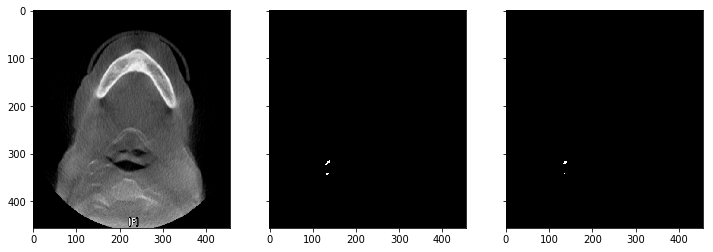

In [52]:
# Test the model

testGenerator = GrayImageDataProvider("data/test_full/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
#testGenerator = CropDataProvider("data/test/*.png", augment_data=False, size=PATCH_SIZE, only_positive=False)
x_test, y_test = testGenerator(1)
testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)
prediction = testNet.predict("./unet_trained/model.ckpt", x_test)
mask = prediction[0,...,1] > 0.05
#mask = prediction[0,...,1]
mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(mask, aspect="auto")



In [16]:
# def pad_array(a, ref, x_offset, y_offset):
#     result = np.zeros_like(ref)
#     result[x_offset:a.shape[0]+x_offset, y_offset:a.shape[1]+y_offset] = a
#     return result

In [17]:
# # Test the model

# testGenerator = GrayImageDataProvider("data/test_full/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
# testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)

# data_test, labels_test = testGenerator(1)

# uberPrediction = np.zeros((456, 456))

# for i in range(200):
#     data_cropped, labels_cropped, x_offset, y_offset, x_flip, y_flip = randomPatch(data_test[0], labels_test[0], PATCH_SIZE, PATCH_SIZE)
#     print(x_flip, y_flip)
#     data_cropped = np.array([data_cropped])
#     labels_cropped = np.array([labels_cropped])
#     prediction = testNet.predict("./unet_trained/model.ckpt", data_cropped)
#     prediction = prediction[0,...,1] > 0.5
#     prediction = np.pad(prediction, 20, 'constant', constant_values=False)

#     #unflip
#     if x_flip == True:
#         print('flipping lr')
#         prediction = np.fliplr(prediction)
#     if y_flip == True:
#         print('flipping ud')
#         prediction = np.flipud(prediction)
    
#     #uncrop
#     prediction = pad_array(prediction, uberPrediction, x_offset, y_offset)

#     uberPrediction = np.maximum(uberPrediction, prediction)

# # no theory
# oneshot_prediction = testNet.predict("./unet_trained/model.ckpt", data_test)
# oneshot_prediction = oneshot_prediction[0,...,1] > 0.5
# oneshot_prediction = np.pad(oneshot_prediction, 20, 'constant', constant_values=False)


# fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))
# ax[0].imshow(data_test[0,...,0], aspect="auto")
# ax[1].imshow(labels_test[0,...,1], aspect="auto")
# ax[2].imshow(uberPrediction, aspect="auto")
# ax[3].imshow(oneshot_prediction, aspect="auto")

